In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import py4DSTEM
import plotly.graph_objects as go
import plotly.io as pio
from scipy import interpolate
from scipy.ndimage import gaussian_filter
from mpl_toolkits.axes_grid1 import make_axes_locatable

def csv_to_numpy(file_path):
    df = pd.read_csv(file_path, header=None)  # header=None treats all rows as data
    data_array = df.to_numpy()
    return data_array

def relativistic_velocity(voltage_kV):
    e = 1.602176634e-19       # Elementary charge in coulombs
    m = 9.109e-31             # Electron rest mass in kg
    c = 3.00e8                # Speed of light in m/s
    mc2 = 511e3               # Electron rest energy in eV
    V = voltage_kV * 1e3      # accelerating voltage in volts

    gamma = 1 + (e * V) / (m * c**2)
    v = c * np.sqrt(1 - (1 / gamma**2))
    return v

def plot_vector_displacement_map(displacement_field: np.ndarray, vecScale=70):
    """
    Real part: x-displacement
    Imag part: y-displacement
    """
    if not np.iscomplexobj(displacement_field):
        raise ValueError("Input array must be complex-valued.")

    ny, nx = displacement_field.shape
    x = np.arange(nx)
    y = np.arange(ny)
    X, Y = np.meshgrid(x, y)
    u = displacement_field.real
    v = displacement_field.imag
    magnitude = np.sqrt(u**2 + v**2)

    aspect_ratio = (ny / nx)*0.5
    fig_width = 10
    fig_height = fig_width * aspect_ratio
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    
    Q = ax.quiver(X, Y, u, v, magnitude, angles='xy', scale_units='xy', scale=vecScale, cmap='inferno')
       
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(Q, cax=cax)

    ax.set_title(r"$\vec{E}$ (MV/cm$^2$)",fontsize=16)
    ax.set_xlabel("X (nm)",fontsize=14)
    ax.set_ylabel("Y (nm)",fontsize=14)
    ax.set_xlim(-0.5, nx-0.5)
    ax.set_ylim(-0.5, ny-0.5)
    ax.set_xticks(np.arange(0, nx, 10))
    ax.set_yticks(np.arange(0, ny, 10))
    ax.set_aspect('equal')
    ax.tick_params(axis='both', labelsize=12) 
#     ax.grid(True)
    ax.invert_yaxis()  # optional: match image coordinate system
    plt.tight_layout()
   
    plt.savefig("Efield_vectorMap.png", dpi=300, bbox_inches='tight')
    plt.show()

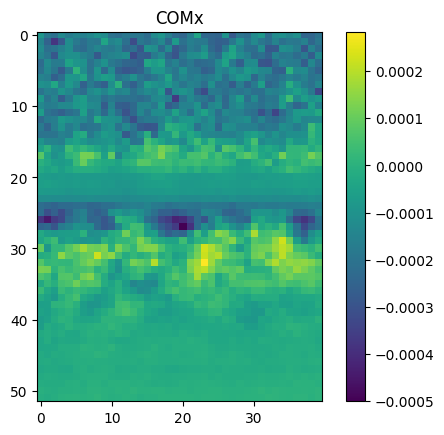

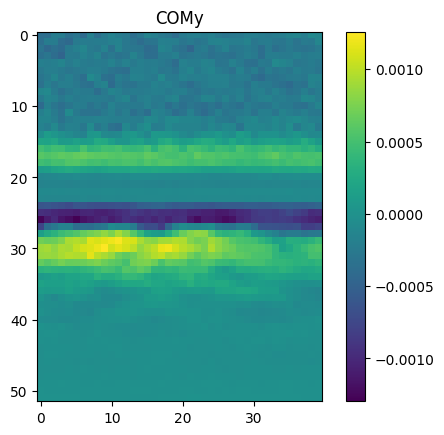

In [39]:
file_path_COMx = '3%Ca_rawData_flipped-COM-x.csv'
file_path_COMy = '3%Ca_rawData_flipped-COM-y.csv'
# file_path_COMx = '1%Ca_new_rawData_flipped_roi-COM-x.csv'
# file_path_COMy = '1%Ca_new_rawData_flipped_roi-COM-y.csv'
calibration = 0.022793 #mrad 0.02265 for 1% - 0.022793 for 3%
COMx = calibration*csv_to_numpy(file_path_COMx)/1000 #rad
# COMx = np.rot90(COMx, 2) 
plt.imshow(COMx, cmap="viridis")
plt.colorbar()
plt.title("COMx")
plt.show()

COMy = calibration*csv_to_numpy(file_path_COMy)/1000 #rad
# COMy = np.rot90(COMy, 2)
plt.imshow(COMy, cmap="viridis")
plt.colorbar()
plt.title("COMy")
plt.show()

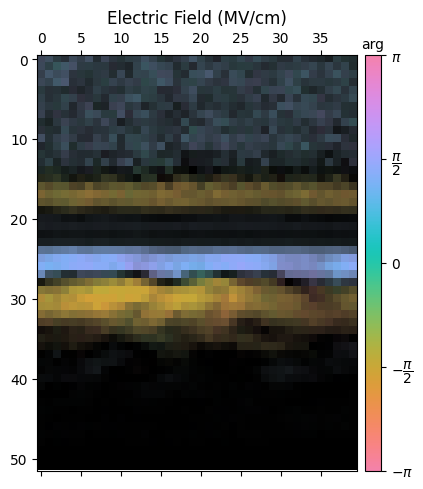

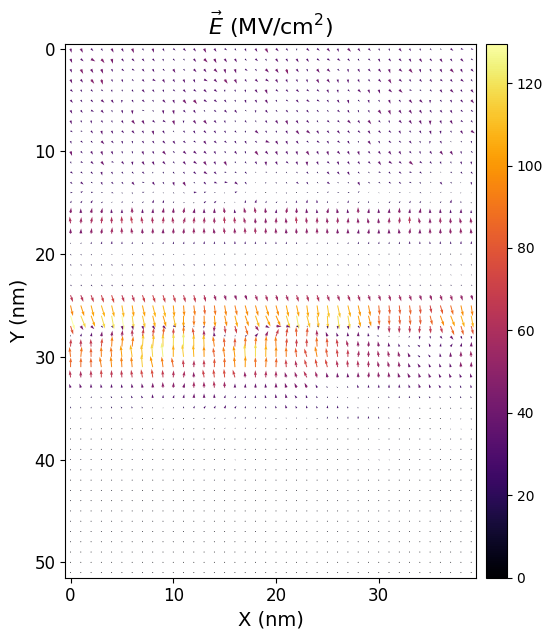

In [41]:
thickness = 35e-9 #m
wavelength = 0.02508e-10 #m
electron_charge = 1.602176634e-19 #Coulomb
planckConstant = 6.62607015e-34 # m2kg/s
velocity = relativistic_velocity(200) 
multiplicativeConstant = (planckConstant*velocity)/(electron_charge*thickness*wavelength)

COMtotal = np.sqrt((COMx**2) + (COMy**2))
angles_rad = np.arctan2(COMy, COMx)
COMtotal_sin = np.sin(COMtotal)
Efield = -COMtotal_sin*multiplicativeConstant/(10**8) 
# in MV/cm

py4DSTEM.show_complex(
    (Efield*np.cos(angles_rad)) + 1j*((Efield*np.sin(angles_rad))),
    ticks=True, 
    title= "Electric Field (MV/cm)"
)
# remember pi/2 is referenced clockwise with respect to the horizontal as reference

displacement = (Efield*np.cos(angles_rad)) + 1j*((Efield*np.sin(angles_rad)))
plot_vector_displacement_map(displacement, vecScale=90) #6 for 1% - 90 for 3%

C:\Users\Sergi Plana Ruiz\AppData\Local\Temp\ipykernel_4128\3967085782.py:1: RuntimeWarning:

invalid value encountered in divide

C:\Users\Sergi Plana Ruiz\AppData\Local\Temp\ipykernel_4128\3967085782.py:2: RuntimeWarning:

invalid value encountered in divide



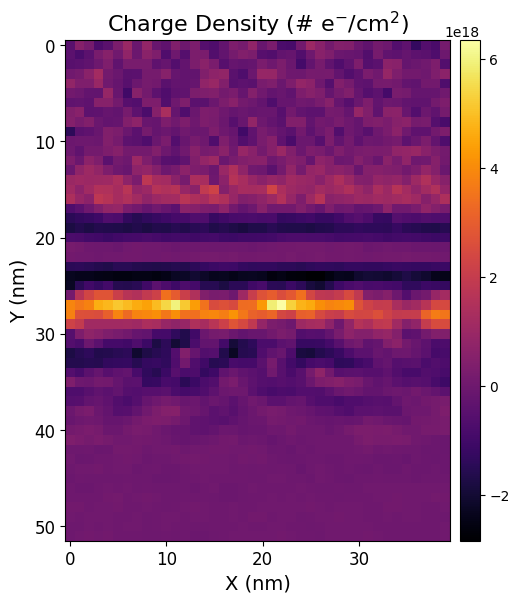

In [42]:
Efieldx = Efield*(COMx/COMtotal)
Efieldy = Efield*(COMy/COMtotal)

dEfield_dx = np.gradient(Efieldx, 1, axis=1)/(10**-9) # 1 pixel = 1 nn
dEfield_dy = np.gradient(Efieldy, 1, axis=0)/(10**-9) # 1 pixel = 1 nn

vacuum_permitivity = 8.8541878188e-12 #C2⋅kg−1⋅m−3⋅s2
divergence_Efield = -vacuum_permitivity*(dEfield_dx + dEfield_dy)*(10**8)/(electron_charge*1e8) # negative to get e- / cm2

##Dealing with NaN values
# Get coordinates of valid and invalid values
x, y = np.indices(divergence_Efield.shape)
x_valid = x[~np.isnan(divergence_Efield)]
y_valid = y[~np.isnan(divergence_Efield)]
values = divergence_Efield[~np.isnan(divergence_Efield)]
# Interpolate at NaN positions
x_nan = x[np.isnan(divergence_Efield)]
y_nan = y[np.isnan(divergence_Efield)]
# Interpolation
interpolated_values = interpolate.griddata((x_valid, y_valid), values, (x_nan, y_nan), method='linear')
# Fill in NaNs with interpolated values
divergence_Efield[np.isnan(divergence_Efield)] = interpolated_values


ny, nx = divergence_Efield.shape
aspect_ratio = (ny / nx)*0.5
fig_width = 10
fig_height = fig_width * aspect_ratio
fig, ax = plt.subplots(figsize=(fig_width, fig_height))
Q = ax.imshow(divergence_Efield, cmap="inferno")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(Q, cax=cax)

ax.set_title("Charge Density (# e$^{-}$/cm$^2$)",fontsize=16)
ax.set_xlabel("X (nm)",fontsize=14)
ax.set_ylabel("Y (nm)",fontsize=14)
ax.set_xlim(-0.5, nx-0.5)
ax.set_ylim(-0.5, ny-0.5)
ax.set_xticks(np.arange(0, nx, 10))
ax.set_yticks(np.arange(0, ny, 10))
ax.invert_yaxis()
ax.tick_params(axis='both', labelsize=12) 
plt.savefig("ChargeDensity.png", dpi=300, bbox_inches='tight')
plt.show()

In [61]:
def plot_3d_distribution_plotly(data: np.ndarray, gaussian_smooth=0, title="", colormap="Viridis",
                                 z_aspect_ratio=0.01, save_html=None,save_png=None, png_scale=4):
    
    if data.ndim != 2:
        raise ValueError("Input data must be a 2D array.")
    
    data = gaussian_filter(data,sigma=gaussian_smooth)
    
    ny, nx = data.shape
    x = np.arange(nx)
    y = np.arange(ny)
    X, Y = np.meshgrid(x, y)
    
    surface = go.Surface(
        z=data,
        x=X,
        y=Y,
        colorscale=colormap,
        colorbar=dict(title="ρ (e-/cm2)", 
                      titlefont=dict(color='black'),
                      showticklabels=True,
                      tickformat=".0E",
                      tickfont=dict(color='black'),
                      tickcolor='black', len=0.7),
    )
    
    fig = go.Figure(data=[surface])

    fig.update_layout(
        template='none',
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)',
        title=title,
        scene=dict(
            xaxis=dict(
                title="X (nm)",
                titlefont=dict(color='black'),
                showgrid=False,
                showline=True,
                showticklabels=True,
                linecolor='black',
                tickfont=dict(color='black'),
                tickcolor='black',
                ticklen=5,
                zeroline=False,
                range=[0, nx]
            ),
            yaxis=dict(
                title="Y (nm)",
                titlefont=dict(color='black'),
                showgrid=False,
                showline=True,
                showticklabels=True,
                linecolor='black',
                tickfont=dict(color='black'),
                tickcolor='black',
                ticklen=5,
                zeroline=False,
                range=[0, ny]
            ),
            zaxis=dict(
                title="",
                showgrid=False,
                showline=False,
                showticklabels=False,
                ticks='', 
                ticklen=0,  
                zeroline=False,
                range=[-8e+18,+7e18] # for 3%Ca
#                 range=[-8e+17,+7e17] # for 1%Ca
            ),
            aspectratio=dict(x=1, y=1, z=z_aspect_ratio),
            camera=dict(
                eye= dict(x= -1.4920781195275459,y=-0.9053317031672856,z=0.886245794863215),
                up= dict(x= 0.42138398069562655, y=0.3527468783861367,z=0.8354670433966526),
                center=dict(x= -0.04776886142988912, y=0.18479733983603006, z= -0.3024885895028111),
                projection=dict(type="orthographic")
            )
        ),
        margin=dict(l=10, r=10, b=10, t=40),
        
    )
    
    if save_html:
        pio.write_html(fig, file=save_html, full_html=True, include_plotlyjs="cdn", auto_open=False, div_id="myPlot")
        print(f"Saved to: {save_html}")
        
    if save_png:
        fig.write_image(save_png, scale=png_scale, engine="kaleido")
        print(f"Saved PNG to: {save_png}")

    fig.show()

In [63]:
plot_3d_distribution_plotly(divergence_Efield[::-1], gaussian_smooth=1, z_aspect_ratio=1, title="",
                            colormap="Inferno",save_html = "ChargeDensity_3Dvisualization.html",
                            save_png="ChargeDensity_3Dvisualization.png")

"""
To get the camera values use the following script when visualization opened in an html through the console (F12) 
const gd = document.getElementById('myPlot');

gd.on('plotly_relayout', function(eventdata) {
  if (eventdata['scene.camera']) {
    console.log("Camera state:");
    console.log(JSON.stringify(eventdata['scene.camera'], null, 2));
  }
});
"""

Saved to: ChargeDensity_3Dvisualization.html
Saved PNG to: ChargeDensity_3Dvisualization.png


'\nTo get the camera values use the following script when visualization opened in an html through the console (F12) \nconst gd = document.getElementById(\'myPlot\');\n\ngd.on(\'plotly_relayout\', function(eventdata) {\n  if (eventdata[\'scene.camera\']) {\n    console.log("Camera state:");\n    console.log(JSON.stringify(eventdata[\'scene.camera\'], null, 2));\n  }\n});\n'